In [1]:
from src.generator import data_generator, clip_generator, label_generator
from src.util import characters, id_from_char, char_from_id
from src.models import create_model

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [2]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [ ]:
# # to make a new model
# model = create_model()

In [4]:
# # to load the saved model
# model = keras.models.load_model('models/cnn_model')
# model.summary()

# Testing

In [5]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [6]:
batch_size = 100
skip = None    # no skip because first 100k clips are test data
step = 7       # to ensure that consecutive clips aren't from the same player and game
repeat = True  # keep this as True, allows generator to loop through database infinitley
limit = 100000 # only look at test data (first 100k clips)

num_batches = 50

In [7]:
data_test = data_generator(clip_collection=collection,
                           batch_size = batch_size,
                           skip=skip,
                           step=step,
                           repeat=repeat,
                           limit=limit)

X_test = clip_generator(clip_collection=collection,
                        batch_size = batch_size,
                        skip=skip,
                        step=step,
                        repeat=repeat,
                        limit=limit)

Y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit, 
                         onehot=True)

y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit,
                         onehot=False)

In [8]:
score = model.evaluate(data_test, steps=num_batches, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

50/50 [==============================] - 34s 678ms/step - loss: 0.0418 - accuracy: 0.9346 - top 8 accuracy: 0.9808

Test score: 0.042
Test accuracy: 93%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [9]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [10]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [11]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

pred = np.argmax(model.predict(X_test, steps=num_batches, verbose=1), axis = 1)
labels = np.concatenate([next(y_test) for _ in range(num_batches)])

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

50/50 [==============================] - 34s 685ms/step


<AxesSubplot:>

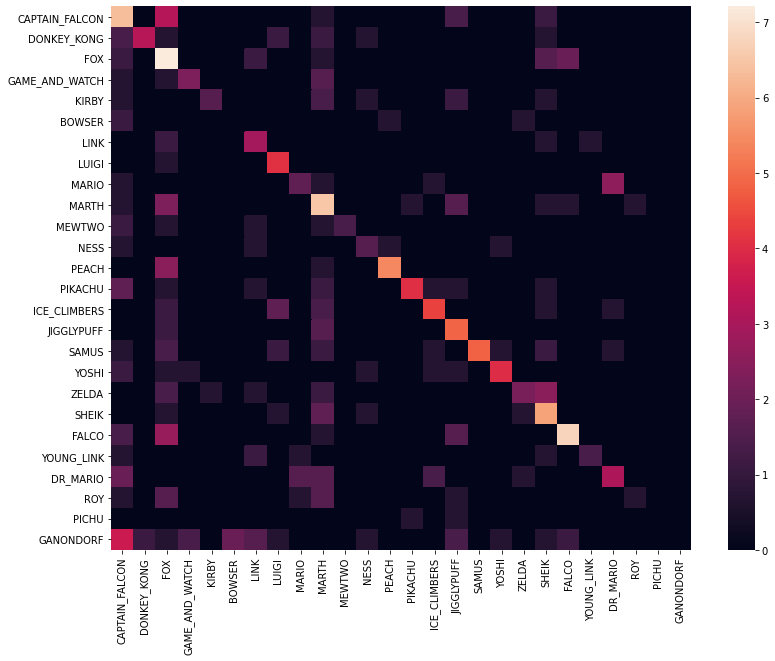

In [12]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)

# Training

In [ ]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [ ]:
# skip first 100k clips and save them as test data
data = data_generator(collection, batch_size=100, skip=100000, step=11, repeat=True)

In [ ]:
model.fit(data, epochs=10, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

In [ ]:
# model.save('models/cnn_model')